In [ ]:
# https://hunkim.github.io/ml/
# https://deeplearningzerotoall.github.io/season2/ 이건 딥러닝

In [ ]:
# 아타리 게임에 적용한 강화학습이 대표적인 케이스임

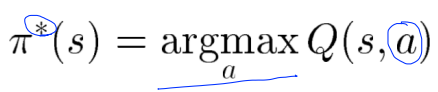

In [7]:
# 현재 상태(s)에서 특정행동(a)을 취했을 때 가장 높은 값(maxQ)을 취할 수 있는 arguments를 구하는 것이 강화학습의 목표임

In [ ]:
# 로보어드바이저를 만들 때 강화학습이 주로 쓰임

In [ ]:
# 뭔가 에러남

In [31]:
import time
import numpy as np
import tkinter as tk
from PIL import ImageTk, Image

PhotoImage = ImageTk.PhotoImage
UNIT = 50  # 픽셀 수
HEIGHT = 5  # 그리드 세로
WIDTH = 5  # 그리드 가로

np.random.seed(1)


class Env(tk.Tk):
    def __init__(self, render_speed=0.01):
        super(Env, self).__init__()
        self.render_speed=render_speed
        self.action_space = ['u', 'd', 'l', 'r']
        self.action_size = len(self.action_space)
        self.title('REINFORCE')
        self.geometry('{0}x{1}'.format(HEIGHT * UNIT, HEIGHT * UNIT))
        self.shapes = self.load_images()
        self.canvas = self._build_canvas()
        self.counter = 0
        self.rewards = []
        self.goal = []
        # 장애물 설정
        self.set_reward([0, 1], -1)
        self.set_reward([1, 2], -1)
        self.set_reward([2, 3], -1)
        # 목표 지점 설정
        self.set_reward([4, 4], 1)

    def _build_canvas(self):
        canvas = tk.Canvas(self, bg='white',
                           height=HEIGHT * UNIT,
                           width=WIDTH * UNIT)
        # 그리드 생성
        for c in range(0, WIDTH * UNIT, UNIT):  # 0~400 by 80
            x0, y0, x1, y1 = c, 0, c, HEIGHT * UNIT
            canvas.create_line(x0, y0, x1, y1)
        for r in range(0, HEIGHT * UNIT, UNIT):  # 0~400 by 80
            x0, y0, x1, y1 = 0, r, HEIGHT * UNIT, r
            canvas.create_line(x0, y0, x1, y1)

        self.rewards = []
        self.goal = []
        # 캔버스에 이미지 추가
        x, y = UNIT/2, UNIT/2
        self.rectangle = canvas.create_image(x, y, image=self.shapes[0])

        canvas.pack()

        return canvas

    def load_images(self):
        rectangle = PhotoImage(
            Image.open("../img/rectangle.png").resize((30, 30)))
        triangle = PhotoImage(
            Image.open("../img/triangle.png").resize((30, 30)))
        circle = PhotoImage(
            Image.open("../img/circle.png").resize((30, 30)))

        return rectangle, triangle, circle

    def reset_reward(self):

        for reward in self.rewards:
            self.canvas.delete(reward['figure'])

        self.rewards.clear()
        self.goal.clear()
        self.set_reward([0, 1], -1)
        self.set_reward([1, 2], -1)
        self.set_reward([2, 3], -1)

        # #goal
        self.set_reward([4, 4], 1)

    def set_reward(self, state, reward):
        state = [int(state[0]), int(state[1])]
        x = int(state[0])
        y = int(state[1])
        temp = {}
        if reward > 0:
            temp['reward'] = reward
            temp['figure'] = self.canvas.create_image((UNIT * x) + UNIT / 2,
                                                       (UNIT * y) + UNIT / 2,
                                                       image=self.shapes[2])

            self.goal.append(temp['figure'])


        elif reward < 0:
            temp['direction'] = -1
            temp['reward'] = reward
            temp['figure'] = self.canvas.create_image((UNIT * x) + UNIT / 2,
                                                      (UNIT * y) + UNIT / 2,
                                                      image=self.shapes[1])

        temp['coords'] = self.canvas.coords(temp['figure'])
        temp['state'] = state
        self.rewards.append(temp)

    # new methods
    def check_if_reward(self, state):
        check_list = dict()
        check_list['if_goal'] = False
        rewards = 0

        for reward in self.rewards:
            if reward['state'] == state:
                rewards += reward['reward']
                if reward['reward'] == 1:
                    check_list['if_goal'] = True

        check_list['rewards'] = rewards

        return check_list

    def coords_to_state(self, coords):
        x = int((coords[0] - UNIT / 2) / UNIT)
        y = int((coords[1] - UNIT / 2) / UNIT)
        return [x, y]

    def reset(self):
        self.update()
        time.sleep(0.5)
        x, y = self.canvas.coords(self.rectangle)
        self.canvas.move(self.rectangle, UNIT / 2 - x, UNIT / 2 - y)
        self.reset_reward()
        return self.get_state()

    def step(self, action):
        self.counter += 1
        self.render()

        if self.counter % 2 == 1:
            self.rewards = self.move_rewards()

        next_coords = self.move(self.rectangle, action)
        check = self.check_if_reward(self.coords_to_state(next_coords))
        done = check['if_goal']
        reward = check['rewards']

        self.canvas.tag_raise(self.rectangle)

        s_ = self.get_state()

        return s_, reward, done

    def get_state(self):

        location = self.coords_to_state(self.canvas.coords(self.rectangle))
        agent_x = location[0]
        agent_y = location[1]

        states = list()

        for reward in self.rewards:
            reward_location = reward['state']
            states.append(reward_location[0] - agent_x)
            states.append(reward_location[1] - agent_y)
            if reward['reward'] < 0:
                states.append(-1)
                states.append(reward['direction'])
            else:
                states.append(1)

        return states

    def move_rewards(self):
        new_rewards = []
        for temp in self.rewards:
            if temp['reward'] == 1:
                new_rewards.append(temp)
                continue
            temp['coords'] = self.move_const(temp)
            temp['state'] = self.coords_to_state(temp['coords'])
            new_rewards.append(temp)
        return new_rewards

    def move_const(self, target):

        s = self.canvas.coords(target['figure'])

        base_action = np.array([0, 0])

        if s[0] == (WIDTH - 1) * UNIT + UNIT / 2:
            target['direction'] = 1
        elif s[0] == UNIT / 2:
            target['direction'] = -1

        if target['direction'] == -1:
            base_action[0] += UNIT
        elif target['direction'] == 1:
            base_action[0] -= UNIT

        if (target['figure'] is not self.rectangle
           and s == [(WIDTH - 1) * UNIT, (HEIGHT - 1) * UNIT]):
            base_action = np.array([0, 0])

        self.canvas.move(target['figure'], base_action[0], base_action[1])

        s_ = self.canvas.coords(target['figure'])

        return s_

    def move(self, target, action):
        s = self.canvas.coords(target)

        base_action = np.array([0, 0])

        if action == 0:  # 상
            if s[1] > UNIT:
                base_action[1] -= UNIT
        elif action == 1:  # 하
            if s[1] < (HEIGHT - 1) * UNIT:
                base_action[1] += UNIT
        elif action == 2:  # 우
            if s[0] < (WIDTH - 1) * UNIT:
                base_action[0] += UNIT
        elif action == 3:  # 좌
            if s[0] > UNIT:
                base_action[0] -= UNIT

        self.canvas.move(target, base_action[0], base_action[1])

        s_ = self.canvas.coords(target)

        return s_

    def render(self):
        # 게임 속도 조정
        time.sleep(self.render_speed)
        self.update()

In [32]:
import copy
import pylab
import random
import numpy as np
# from environment import Env
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


# 상태가 입력, 각 행동의 확률이 출력인 인공신경망 생성
class REINFORCE(tf.keras.Model):
    def __init__(self, action_size):
        super(REINFORCE, self).__init__()
        self.fc1 = Dense(24, activation='relu')
        self.fc2 = Dense(24, activation='relu')
        self.fc_out = Dense(action_size, activation='softmax')

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        policy = self.fc_out(x)
        return policy


# 그리드월드 예제에서의 REINFORCE 에이전트
class REINFORCEAgent:
    def __init__(self, state_size, action_size):
        # 상태의 크기와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size
        
        # REINFORCE 하이퍼 파라메터
        self.discount_factor = 0.99
        self.learning_rate = 0.001

        self.model = REINFORCE(self.action_size)
        self.optimizer = Adam(lr=self.learning_rate)
        self.states, self.actions, self.rewards = [], [], []

    # 정책신경망으로 행동 선택
    def get_action(self, state):
        policy = self.model(state)[0]
        policy = np.array(policy)
        return np.random.choice(self.action_size, 1, p=policy)[0]

    # 반환값 계산
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    # 한 에피소드 동안의 상태, 행동, 보상을 저장
    def append_sample(self, state, action, reward):
        self.states.append(state[0])
        self.rewards.append(reward)
        act = np.zeros(self.action_size)
        act[action] = 1
        self.actions.append(act)

    # 정책신경망 업데이트
    def train_model(self):
        discounted_rewards = np.float32(self.discount_rewards(self.rewards))
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)
        
        # 크로스 엔트로피 오류함수 계산
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            tape.watch(model_params)
            policies = self.model(np.array(self.states))
            actions = np.array(self.actions)
            action_prob = tf.reduce_sum(actions * policies, axis=1)
            cross_entropy = - tf.math.log(action_prob + 1e-5)
            loss = tf.reduce_sum(cross_entropy * discounted_rewards)
            entropy = - policies * tf.math.log(policies)

        # 오류함수를 줄이는 방향으로 모델 업데이트
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))
        self.states, self.actions, self.rewards = [], [], []
        return np.mean(entropy)


if __name__ == "__main__":
    # 환경과 에이전트 생성
    env = Env(render_speed=0.01)
    state_size = 15
    action_space = [0, 1, 2, 3, 4]
    action_size = len(action_space)
    agent = REINFORCEAgent(state_size, action_size)

    scores, episodes = [], []

    EPISODES = 200
    for e in range(EPISODES):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            # 현재 상태에 대한 행동 선택
            action = agent.get_action(state)

            # 선택한 행동으로 환경에서 한 타임스텝 진행 후 샘플 수집
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            agent.append_sample(state, action, reward)
            score += reward

            state = next_state

            if done:
                # 에피소드마다 정책신경망 업데이트
                entropy = agent.train_model()
                # 에피소드마다 학습 결과 출력
                print("episode: {:3d} | score: {:3d} | entropy: {:.3f}".format(
                      e, score, entropy))

                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.xlabel("episode")
                pylab.ylabel("score")
                pylab.savefig("./save_graph/graph.png")
                

        # 100 에피소드마다 모델 저장
        if e % 100 == 0:
            agent.model.save_weights('save_model/model', save_format='tf')

TclError: image "pyimage25" doesn't exist